#  Classification via Probabilistic Modeling

In this lab, we will practice working with Bayesian probabilistic modeling.

You will implement a probabilistic model of your own design from Homework 3, and you will also use the generalization of Naive Bayes Classification for classification on the breast cancer dataset from our logistic regression demo.

## Warm Up: Implementing a Probabilisitc Model 

Implement the probabilistic model you came up with for Problem 1, part (a) on written homework 3. Limit your model to only include data for any **three zipcodes** of your choice in New York City.

You will probably want to use one or more functions in the `numpy.random` package.

Feel free to simply select reasonable parameters for your model using your own intuition, but **bonus points will be given if you use outside data to inform the model.** Please include a link to any outside sources and explain how the data was used. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def generate_rent_data(n):
    """
    Randomly generate a synthetic dataset of apartment rental data with n examples.
    Return: X, a n x 2 numpy array, where the first column contains a zip code and
    the second contains a square footage number.
    y, an n x 1 numpy array containing a monthly rental price
    
    """
    
    return X,y

My solution is very loosely data informed. I looked at some data from https://www.rentcafe.com/average-rent-market-trends/us/ny/manhattan/ and https://www.rentcafe.com/average-rent-market-trends/us/ny/brooklyn/ to get a sense of slopes for different neighborhoods, but choose intercepts arbitrarily, and he noise variance arbitraily. This website was used to figure out zip codes populations, which are used as a proxy for number of apartments: https://www.zip-codes.com/zip-code/10012/zip-code-10012.asp.

In [3]:
zips = np.array([10012,11201,10463])
pops = np.array([24175,67506,67985])
mu_size = np.array([706,651,706])
sigma_size = mu_size/5
average_price = np.array([5641,3721,1708])
sigma_price = average_price/5
beta0 = 500*(average_price/np.min(average_price))
beta1 = (average_price - beta0)/mu_size
thresh1 = pops[0]/np.sum(pops)
thresh2 = thresh1 + pops[1]/np.sum(pops)

In [4]:
beta1

array([5.65106713, 4.04257187, 1.71104816])

In [5]:
def generate_rent_data(n):
    """
    Randomly generate a synthetic dataset of apartment rental data with n examples.
    Return: X, a n x 2 numpy array, where the first column contains a zip code and
    the second contains a square footage number.
    y, an n x 1 numpy array containing a monthly rental price
    
    """
    X = np.zeros((n,2))
    y = np.zeros(n)
    t = np.random.rand(n)
    ind0 = t <= thresh1
    ind1 = (t > thresh1)*(t < thresh2)
    ind2 = t >= thresh2
    X[ind0,0] = zips[0]
    X[ind1,0] = zips[1]
    X[ind2,0] = zips[2]
    X[ind0,1] = mu_size[0] + sigma_size[0]*np.random.randn(sum(ind0))
    X[ind1,1] = mu_size[1] + sigma_size[1]*np.random.randn(sum(ind1))
    X[ind2,1] = mu_size[2] + sigma_size[2]*np.random.randn(sum(ind2))
    y[ind0] = beta0[0] + beta1[0]*X[ind0,1] + sigma_price[0]*np.random.randn(sum(ind0))
    y[ind1] = beta0[1] + beta1[1]*X[ind1,1] + sigma_price[1]*np.random.randn(sum(ind1))
    y[ind2] = beta0[2] + beta1[2]*X[ind2,1] + sigma_price[2]*np.random.randn(sum(ind2))
    
    
    return X,y

Generate 1000 data examples using the probabilistic model implemented in `generate_rent_data(n)`. Plot the data on a scatter plot, with the x-axis being apartment size and the y-axis being rent. Color each data points to indicate which of the three zip codes it is from. 

Confirm that the data looks reasonable for the zip codes you selected! I have provided an example result below:

<img src="sample_output.png" width="400">

Your data will look different depending on how you designed your probabilistic model.


In [6]:
X,y = generate_rent_data(1000)

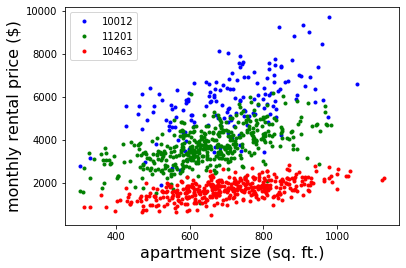

In [7]:
ind0 = X[:,0] == zips[0]
ind1 = X[:,0] == zips[1]
ind2 = X[:,0] == zips[2]
plt.plot(X[ind0,1],y[ind0],'b.')
plt.plot(X[ind1,1],y[ind1],'g.')
plt.plot(X[ind2,1],y[ind2],'r.')
plt.xlabel("apartment size (sq. ft.)", fontsize=16)
plt.ylabel("monthly rental price ($)", fontsize=16)
plt.legend(zips)

##  Breast Cancer Diagnosis via Gaussian Naive Bayes

In this portion of the lab, we will revisit the Breast Cancer Diagnosis problem from `demo_breast_cancer_scratch.ipynb` and try to classifiy examples using the Gaussian Naive Bayes method developed in Problem 2 of Homework 3.

As a reminder, the data set is described here:
https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(original) 

and more information on the problem can be found in the demo.

### Loading and Visualizing the Data

We first load the packages and data as in the demo.

In [8]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets, linear_model, preprocessing
%matplotlib inline
names = ['id','thick','size_unif','shape_unif','marg','cell_size','bare',
         'chrom','normal','mit','class']
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/' +
                 'breast-cancer-wisconsin/breast-cancer-wisconsin.data',
                names=names,na_values='?',header=None)
df = df.dropna()

# Get the response.  Convert to a zero-one indicator 
yraw = np.array(df['class'])
BEN_VAL = 2   # value in the 'class' label for benign samples
MAL_VAL = 4   # value in the 'class' label for malignant samples
y = (yraw == MAL_VAL).astype(int) # now y has values of 0,1 
Iben = (y==0)
Imal = (y==1)

For this lab we are going to use all predictors we have at our disposal, as was done at the end of the demo. The code below places all of the predictor data in a matrix `Xfull` of dimension (n x d). 

In [9]:
xnames = names[:-1]
Xfull = np.array(df[xnames])
n = Xfull.shape[0]
d = Xfull.shape[1]

### Naive Bayes Classification

The first step in using the Gaussian Naive Bayes method is to estimate all parameters of the probabilistic model. These include:
* `p` -- the probability that a data example is malignant (label 1)
* `mub` = `[mub[0], \ldots, mub[d-1]]` -- the expected value of each predictor variable for benign examples.
* `sigb` = `[sigb[0], \ldots, sigb[d-1]]` -- the variance value of each predictor variable for benign examples.
* `mum` = `[mum[0], \ldots, mum[d-1]]` -- the expected value of each predictor variable for malignant examples.
* `sigm` = `[sigm[0], \ldots, sigm[d-1]]` -- the variance value of each predictor variable for maglignant examples.

Compute estimates for these values below using teh data in `Xfull`. 

**Hint**: For a compact approach, you might want to use the boolean arrays `Imal` and `Iben` created above for "mask indexing" (see [these docs](https://docs.scipy.org/doc/numpy/user/basics.indexing.html)).

In [10]:
# TODO
# p = ...
# mub = ..
# sigb = ...
# mum = ..
# sigm = ...

In [11]:
p = sum(Imal)/y.shape[0]
mub = np.mean(Xfull[Iben],axis=0)
sigb = np.var(Xfull[Iben]-mub,axis=0)
mum = np.mean(Xfull[Imal],axis=0)
sigm = np.var(Xfull[Imal]-mum,axis=0)

Next, for every row $\vec{x}$ in `Xfull`, use the model parameters determined above to compute the maximum a posterior (MAP) estimate for the class label $y$. You should use the equations derived in your solution to Problem 3 (b) on the homework. 

You may need to be thoughtful in how you do this computation to avoid numerical underflow or overflow in your computations: keep in mind that you just need to determine which of $p(y=0 | \vec{x})$ or $p(y=1 | \vec{x})$ is **larger** -- you don't necessarily need to compute both values explicitly. 

Store your MAP estimates for the data examples in an integer vector `yhat` containing 0s and 1s.

In [12]:
# TODO
# ...
# yhat = 

In [13]:
mprobs = np.log(p) - np.sum(np.log(sigm)) - np.sum((Xfull - mum)**2/sigm/2, axis=1)
bprobs = np.log(1-p) - np.sum(np.log(sigb)) - np.sum((Xfull - mub)**2/sigb/2, axis=1)

In [14]:
yhat = (mprobs > bprobs).astype(int)

Compute the accuracy of your estimates using the code below. You should see a result which is very competitive with logistic regression, which is pretty cool given how simple this algorithm is!

**Note**: we would ideally want to do a proper train/test split to evaluate the performance of both logistic regression and Naive Bayes classification. We're just looking at training set loss to keep things simple, and because the number of features is relatively small, so we're not super worried about overfitting.

In [15]:
acc = np.mean(yhat == y)
print("Accuracy on training data = %f" % acc)
recall = np.sum((yhat == 1)*(y == 1))/np.sum(y == 1)
precision = np.sum((yhat == 1)*(y == 1))/np.sum(yhat == 1)
print("Recall: " + str(recall))
print("Precision: " + str(precision))

Accuracy on training data = 0.961933
Recall: 0.9665271966527197
Precision: 0.927710843373494
